In [1]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=883e6a862dfe9215461417c53713811866a86122887be4863d0c1236f98d020f
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [2]:
pip install wilds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import numpy as np
import time


**SIMPLE TRAINING OF TEACHER MODEL, WITHOUT JITTER ON THE DATASET**
trained for only 20 epochs

In [6]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = get_dataset(dataset="waterbirds", download=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = dataset.get_subset("train", transform=transform)
val_data = dataset.get_subset("val", transform=transform)
test_data = dataset.get_subset("test", transform=transform)

train_loader = get_train_loader("standard", train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

student_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', pretrained=True)
student_model.fc = nn.Linear(student_model.fc.in_features, 2)  # Adjusting for 2 classes
student_model = student_model.to(DEVICE)

#######################
# Training Loop
#######################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    student_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for batch in tqdm(train_loader, desc="Training"):
        images, labels = batch[0], batch[1] 
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = student_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Training: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s]


Loss: 0.3059, Accuracy: 88.82%
Epoch 2/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Loss: 0.1984, Accuracy: 92.30%
Epoch 3/20


Training: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]


Loss: 0.1599, Accuracy: 93.76%
Epoch 4/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Loss: 0.1486, Accuracy: 94.20%
Epoch 5/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Loss: 0.0988, Accuracy: 96.08%
Epoch 6/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Loss: 0.0791, Accuracy: 96.64%
Epoch 7/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Loss: 0.0741, Accuracy: 97.33%
Epoch 8/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Loss: 0.0534, Accuracy: 97.89%
Epoch 9/20


Training: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]


Loss: 0.0629, Accuracy: 97.58%
Epoch 10/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Loss: 0.0399, Accuracy: 98.77%
Epoch 11/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


Loss: 0.0431, Accuracy: 98.50%
Epoch 12/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Loss: 0.0452, Accuracy: 98.35%
Epoch 13/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Loss: 0.0130, Accuracy: 99.67%
Epoch 14/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Loss: 0.0358, Accuracy: 98.79%
Epoch 15/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Loss: 0.0433, Accuracy: 98.64%
Epoch 16/20


Training: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s]


Loss: 0.0247, Accuracy: 99.33%
Epoch 17/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Loss: 0.0266, Accuracy: 99.19%
Epoch 18/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Loss: 0.0161, Accuracy: 99.48%
Epoch 19/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Loss: 0.0178, Accuracy: 99.52%
Epoch 20/20


Training: 100%|██████████| 150/150 [00:33<00:00,  4.49it/s]

Loss: 0.0443, Accuracy: 98.46%


Evaluating the unjittered model

In [2]:
def evaluate_model(model, data_loader, device, criterion):
    """
    Evaluate the model on a given dataset.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to run the evaluation on (CPU/GPU).
        criterion (nn.Module): Loss function to calculate loss.

    Returns:
        dict: A dictionary containing loss and accuracy.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images, labels = batch[0], batch[1] 
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return {"loss": avg_loss, "accuracy": accuracy}


criterion = nn.CrossEntropyLoss()

print("Evaluating on IID (Validation) Dataset...")
iid_results = evaluate_model(student_model, val_loader, DEVICE, criterion)
print(f"IID Results: Loss = {iid_results['loss']:.4f}, Accuracy = {iid_results['accuracy']:.2f}%")

print("Evaluating on OOD (Test) Dataset...")
ood_results = evaluate_model(student_model, test_loader, DEVICE, criterion)
print(f"OOD Results: Loss = {ood_results['loss']:.4f}, Accuracy = {ood_results['accuracy']:.2f}%")


Evaluating on IID (Validation) Dataset...
IID Results: Loss = 1.10186, Accuracy = 79.86%
Evaluating on OOD (Test) Dataset...
OOD Results: Loss = 0.9619, Accuracy = 28.32%


In [9]:
# Define transforms with color jitter for training the student
train_transform_with_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


training new model on jittered dataset

In [11]:
train_data_jittered = dataset.get_subset("train", transform=train_transform_with_jitter)
train_loader_jittered = get_train_loader("standard", train_data_jittered, batch_size=BATCH_SIZE)

student_model_jittered = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', pretrained=True)
student_model_jittered.fc = nn.Linear(student_model_jittered.fc.in_features, 2)  # Adjust for 2 classes
student_model_jittered = student_model_jittered.to(DEVICE)
optimizer_jittered = optim.Adam(student_model_jittered.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

print("Training model on jittered dataset...")
for epoch in range(EPOCHS):
    student_model_jittered.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for batch in tqdm(train_loader_jittered, desc="Training"):
      
        images, labels = batch[0], batch[1]
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = student_model_jittered(images)
        loss = criterion(outputs, labels)

        optimizer_jittered.zero_grad()
        loss.backward()
        optimizer_jittered.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Loss: {running_loss / len(train_loader_jittered):.4f}, Accuracy: {100 * correct / total:.2f}%")

print("Training complete for jittered dataset model.")



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Training model on jittered dataset...
Epoch 1/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.3223, Accuracy: 87.63%
Epoch 2/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.15it/s]


Loss: 0.2559, Accuracy: 89.91%
Epoch 3/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.2482, Accuracy: 90.14%
Epoch 4/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.2313, Accuracy: 91.22%
Epoch 5/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.1930, Accuracy: 92.51%
Epoch 6/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.15it/s]


Loss: 0.1653, Accuracy: 93.47%
Epoch 7/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.1372, Accuracy: 94.81%
Epoch 8/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.1130, Accuracy: 95.72%
Epoch 9/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.0992, Accuracy: 96.25%
Epoch 10/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.0820, Accuracy: 96.83%
Epoch 11/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.0724, Accuracy: 97.18%
Epoch 12/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.0581, Accuracy: 98.00%
Epoch 13/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.0468, Accuracy: 98.35%
Epoch 14/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.0366, Accuracy: 98.54%
Epoch 15/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.0437, Accuracy: 98.33%
Epoch 16/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.15it/s]


Loss: 0.0349, Accuracy: 98.60%
Epoch 17/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.0308, Accuracy: 99.04%
Epoch 18/20


Training: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Loss: 0.0226, Accuracy: 99.25%
Epoch 19/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


Loss: 0.0296, Accuracy: 99.06%
Epoch 20/20


Training: 100%|██████████| 150/150 [02:09<00:00,  1.16it/s]

Loss: 0.0199, Accuracy: 99.35%
Training complete for jittered dataset model.


Evaluating jittered model

In [1]:
def evaluate_model(model, data_loader, device, criterion):
    """
    Evaluate the model on a given dataset.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to run the evaluation on (CPU/GPU).
        criterion (nn.Module): Loss function to calculate loss.

    Returns:
        dict: A dictionary containing loss and accuracy.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images, labels = batch[0], batch[1]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return {"loss": avg_loss, "accuracy": accuracy}


# Example Usage for IID and OOD
criterion = nn.CrossEntropyLoss()

# Evaluating on IID Dataset (Validation)
print("Evaluating Jittered Model on IID (Validation) Dataset...")
iid_results = evaluate_model(student_model_jittered, val_loader, DEVICE, criterion)
print(f"IID Results: Loss = {iid_results['loss']:.4f}, Accuracy = {iid_results['accuracy']:.2f}%")

# Evaluating on OOD Dataset (Test)
print("Evaluating Jittered Model on OOD (Test) Dataset...")
ood_results = evaluate_model(student_model_jittered, test_loader, DEVICE, criterion)
print(f"OOD Results: Loss = {ood_results['loss']:.4f}, Accuracy = {ood_results['accuracy']:.2f}%")


Evaluating Jittered Model on IID (Validation) Dataset...
IID Results: Loss = 1.5431, Accuracy = 77.45%
Evaluating Jittered Model on OOD (Test) Dataset...
OOD Results: Loss = 1.478, Accuracy = 36.35%


Grad-CAM for Unjittered Model:


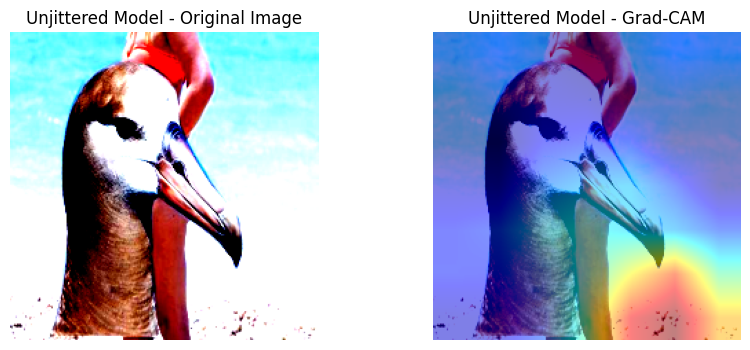

Grad-CAM for Jittered Model:


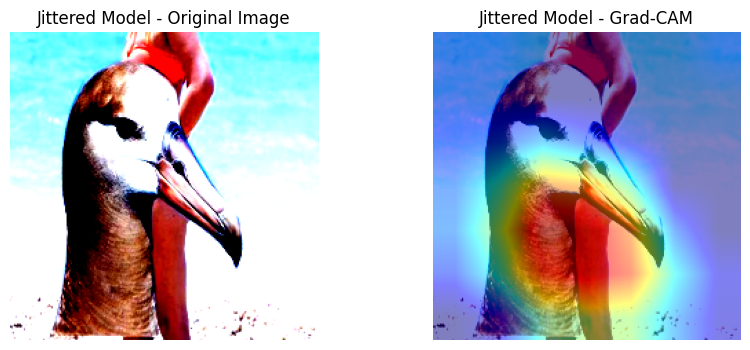

In [15]:
import matplotlib.pyplot as plt
def visualize_gradcam(model, data_loader, layer_name='layer4', model_name='Model'):
    """
    Grab a single batch from data_loader, apply Grad-CAM, and show results on the first image.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        layer_name (str): Layer to visualize Grad-CAM.
        model_name (str): Name of the model for display purposes.
    """
    model.eval()

    # Get the target layer
    target_layer = getattr(model, layer_name)

    # Get a single batch
    data_iter = iter(data_loader)
    batch = next(data_iter)

    # Check the number of outputs in the batch
    if len(batch) == 3:
        images, labels, metadata = batch  # Unpacking for 3 outputs
    elif len(batch) == 2:
        images, labels = batch  # Unpacking for 2 outputs
    else:
        raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    # Visualize the first image in the batch
    input_tensor = images[0].unsqueeze(0)
    input_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
    input_img = np.clip(input_img, 0, 1)

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # [H, W]

    # Convert CAM to RGB heatmap
    visualization = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 4))
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title(f"{model_name} - Original Image")
    plt.axis("off")

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"{model_name} - Grad-CAM")
    plt.axis("off")
    plt.show()

# Grad-CAM for the unjittered model
print("Grad-CAM for Unjittered Model:")
visualize_gradcam(student_model, test_loader, layer_name='layer4', model_name='Unjittered Model')

# Grad-CAM for the jittered model
print("Grad-CAM for Jittered Model:")
visualize_gradcam(student_model_jittered, test_loader, layer_name='layer4', model_name='Jittered Model')
